<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/AE%20ECG%20timeseries%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
url_link = 'https://raw.githubusercontent.com/TAUforPython/BioMedAI/refs/heads/main/test_datasets/ecg_1d_timeseries_prediction.csv'


# --- Configuration ---
input_window = 10  # Number of input steps
output_window = 1  # Number of prediction steps (fixed to one)
batch_size = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load and Prepare Data ---
# Load the ECG data from the uploaded CSV file
# The data seems to be semicolon-separated and has headers in the first row
df = pd.read_csv(url_link, sep=';')

# Check the columns to identify the correct one for the ECG signal
print("Columns in the DataFrame:", df.columns.tolist())

Using device: cpu
Columns in the DataFrame: ['time', 'ecg_value']


In [3]:
# Assuming the ECG signal is in the second column named 'ecg_value'
ecg_signal_column = 'ecg_value'
if ecg_signal_column not in df.columns:
    print(f"Warning: Column '{ecg_signal_column}' not found. Using the first available column after 'time'.")
    ecg_signal_column = df.columns[1] # Second column

series = df[ecg_signal_column].values # Extract the ECG signal as a numpy array
print(f"Original ECG series shape: {series.shape}")

# Optional: Remove any potential NaN values introduced during loading
series = series[~pd.isna(series)]
print(f"ECG series shape after removing NaN: {series.shape}")

# --- Normalize the data ---
# Using MinMaxScaler to bring values into a standard range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
# Reshape for scaler: (n_samples, n_features)
series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()


Original ECG series shape: (17935,)
ECG series shape after removing NaN: (17935,)


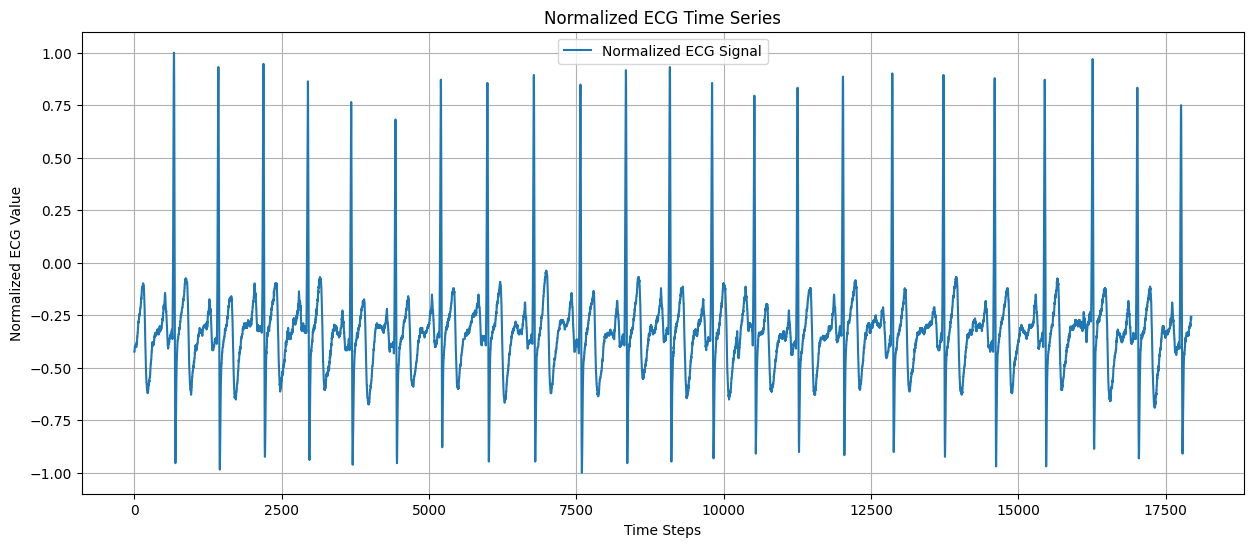

In [4]:
plt.figure(figsize=(15, 6))
plt.plot(series_scaled, label='Normalized ECG Signal')
plt.title('Normalized ECG Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Normalized ECG Value')
plt.legend()
plt.grid(True)
plt.show()

# Autoencoder example

In [16]:
class AutoencoderModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, latent_dim=10):
        super(AutoencoderModel, self).__init__()
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim

        # Encoder: LSTM to compress the input sequence into a hidden state
        # input_size=1 because each time step has a single ECG value
        self.encoder_lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True  # Input and output tensors are provided as (batch, seq, feature)
        )

        # Linear layer to project the LSTM's last hidden state to a latent representation
        self.latent_projection = nn.Linear(hidden_size, latent_dim)

        # Decoder: Linear layer to predict the next value from the latent representation
        # Since output_window is 1, we predict a single value
        self.decoder_linear = nn.Linear(latent_dim, 1)

    def forward(self, x):
        # x shape: (batch_size, input_window, input_size=1)

        # Encoder
        # LSTM returns output, (h_n, c_n)
        # h_n shape: (num_layers * num_directions, batch, hidden_size)
        # Since we have one layer and unidirectional LSTM, h_n will be (1, batch, hidden_size)
        _, (hidden, _) = self.encoder_lstm(x)

        # We take the last hidden state of the LSTM (from the last layer/direction)
        # Squeeze the first dimension to get (batch, hidden_size)
        hidden = hidden.squeeze(0) # Shape: (batch_size, hidden_size)

        # Project to latent space
        latent_representation = self.latent_projection(hidden) # Shape: (batch_size, latent_dim)

        # Decoder
        # Predict the next value from the latent representation
        prediction = self.decoder_linear(latent_representation) # Shape: (batch_size, 1)

        return prediction.unsqueeze(-1) # Add an extra dimension for compatibility with target (batch_size, 1, 1)

In [15]:
print(autoencoder_model)

AutoencoderModel(
  (encoder_lstm): LSTM(1, 64, batch_first=True)
  (latent_projection): Linear(in_features=64, out_features=32, bias=True)
  (decoder_linear): Linear(in_features=32, out_features=1, bias=True)
)


In [17]:
print("\n--- Training Autoencoder Model ---")

# Instantiate the AutoencoderModel
# input_size is 1 for our single ECG value feature
# hidden_size and latent_dim can be tuned, starting with reasonable defaults
autoencoder_model = AutoencoderModel(input_size=1, hidden_size=64, latent_dim=32).to(device)

# Reuse the criterion and learning rate from the Transformer training
# epochs also reused, but can be adjusted for autoencoder specifically
# Note: train_data, val_data, input_window, output_window are already defined

autoencoder_criterion = nn.MSELoss()
autoencoder_lr = 0.0001
autoencoder_epochs = 10 # Using the same number of epochs for comparison

autoencoder_optimizer = torch.optim.AdamW(autoencoder_model.parameters(), lr=autoencoder_lr)
autoencoder_scheduler = torch.optim.lr_scheduler.StepLR(autoencoder_optimizer, step_size=1, gamma=0.98)

autoencoder_train_losses = []
autoencoder_val_losses = []

print("Starting Autoencoder Training...")
for epoch in range(1, autoencoder_epochs + 1):
    epoch_start_time = time.time()
    train_loss_ae = train_epoch(autoencoder_model, train_data, autoencoder_optimizer, autoencoder_criterion)
    val_loss_ae = evaluate(autoencoder_model, val_data, autoencoder_criterion)

    autoencoder_train_losses.append(train_loss_ae)
    autoencoder_val_losses.append(val_loss_ae)

    print(f"-" * 89)
    print(f"| End of epoch {epoch:3d} | Train Loss (AE): {train_loss_ae:.7f} | Val Loss (AE): {val_loss_ae:.7f} | "
          f"Epoch Time: {(time.time() - epoch_start_time):.2f}s")
    print("-" * 89)

    autoencoder_scheduler.step()

print("Autoencoder Training Finished!")


--- Training Autoencoder Model ---
Starting Autoencoder Training...
-----------------------------------------------------------------------------------------
| End of epoch   1 | Train Loss (AE): 0.0006039 | Val Loss (AE): 0.0004543 | Epoch Time: 2.04s
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   2 | Train Loss (AE): 0.0002913 | Val Loss (AE): 0.0001761 | Epoch Time: 1.11s
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   3 | Train Loss (AE): 0.0001469 | Val Loss (AE): 0.0001425 | Epoch Time: 1.11s
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch  

Visualize performance by plotting the training and validation losses over epochs. This will help assess the model's learning progress and identify potential overfitting or underfitting issues.



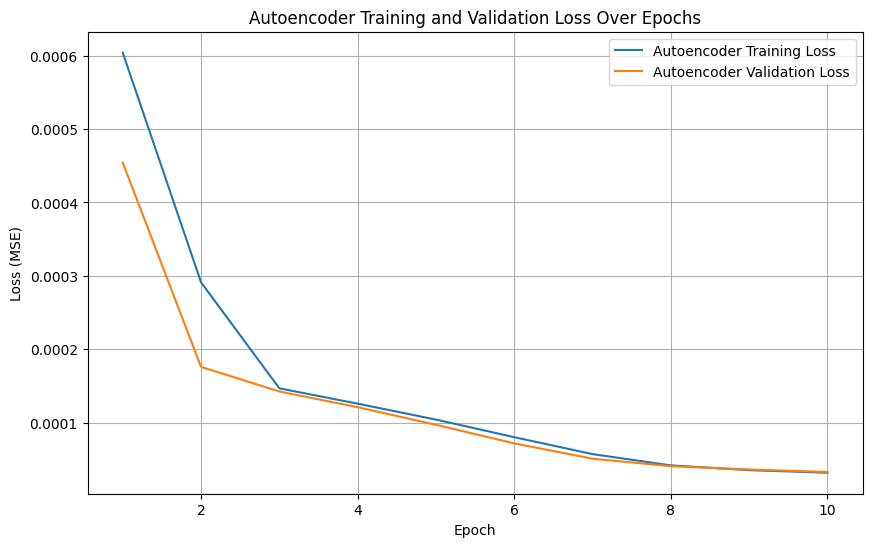

In [18]:
epochs_range_ae = range(1, autoencoder_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range_ae, autoencoder_train_losses, label='Autoencoder Training Loss')
plt.plot(epochs_range_ae, autoencoder_val_losses, label='Autoencoder Validation Loss')
plt.title('Autoencoder Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

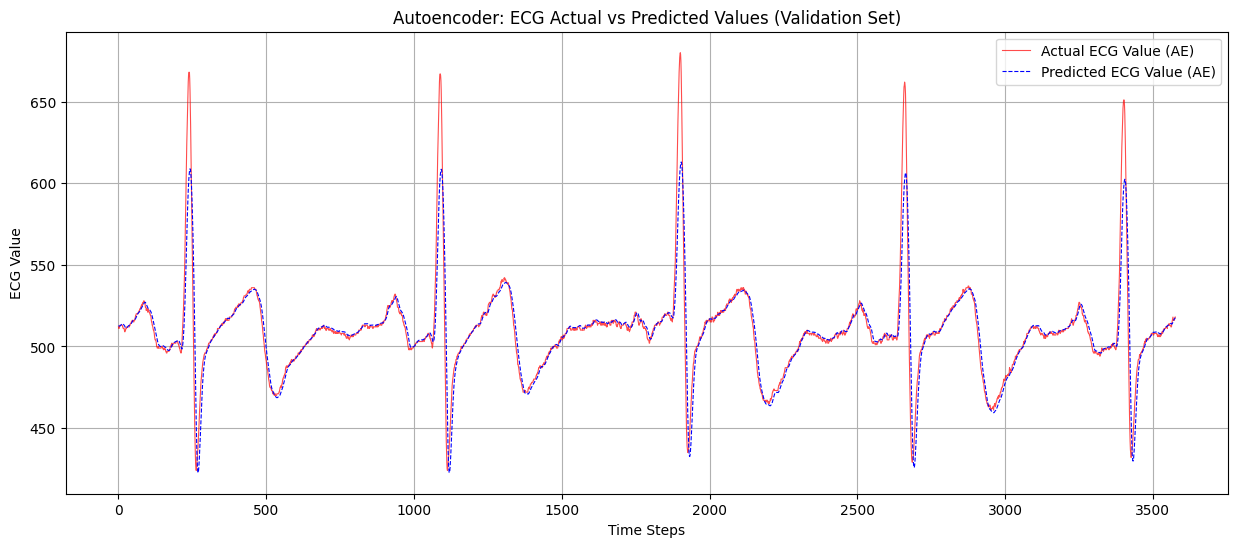

In [19]:
autoencoder_model.eval()
all_predictions_ae = []
all_targets_ae = []
with torch.no_grad():
    for i in range(0, len(val_data), batch_size):
        data, targets = get_batch(val_data, i, batch_size)
        output = autoencoder_model(data)
        all_predictions_ae.extend(output.squeeze().cpu().numpy())
        all_targets_ae.extend(targets.squeeze().cpu().numpy())

# Inverse transform predictions and targets back to original scale
preds_original_ae = scaler.inverse_transform(np.array(all_predictions_ae).reshape(-1, 1)).flatten()
targets_original_ae = scaler.inverse_transform(np.array(all_targets_ae).reshape(-1, 1)).flatten()

plt.figure(figsize=(15, 6))
plt.plot(targets_original_ae, label='Actual ECG Value (AE)', color='red', alpha=0.7, linewidth=0.8)
plt.plot(preds_original_ae, label='Predicted ECG Value (AE)', color='blue', linestyle='--', linewidth=0.8)
plt.title('Autoencoder: ECG Actual vs Predicted Values (Validation Set)')
plt.xlabel('Time Steps')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True)
plt.show()

# Transformer example

In [7]:

# --- Dataset Preparation Functions ---

def create_inout_sequences(input_data, tw, ow):
    """Create input-output pairs for the model.
    Input: sequence of length 'tw'.
    Target: sequence of length 'ow' starting right after the input sequence.
    """
    inout_seq = []
    L = len(input_data)
    # Ensure we don't go out of bounds when creating sequences
    # We need at least tw + ow points to create one sample
    for i in range(L - tw - ow + 1):
        train_seq = input_data[i : i + tw]
        # The target starts exactly after the input sequence ends
        train_label = input_data[i + tw : i + tw + ow]
        # Store as a tuple of (input_tensor, target_tensor)
        # Shape of tensors: (seq_len,) -> (seq_len, 1) when fed to model
        inout_seq.append((torch.FloatTensor(train_seq), torch.FloatTensor(train_label)))
    # Return list of tuples. Batching happens later.
    return inout_seq

def get_data(data, split_ratio):
    """Split data into train and test sequences."""
    split_index = int(split_ratio * len(data))
    train_data = data[:split_index]
    test_data = data[split_index:]

    # Create sequences for training and testing
    train_seq = create_inout_sequences(train_data, input_window, output_window)
    test_seq = create_inout_sequences(test_data, input_window, output_window)

    return train_seq, test_seq

# --- Model Definition (Adjusted for 1D Input and Correct Output) ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape expected: (seq_len, batch_size, d_model)
        # pe is broadcastable to (seq_len, 1, d_model)
        return x + self.pe[:x.size(0), :]

class TransformerModel(nn.Module):
    def __init__(self, feature_size=200, num_layers=1, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_type = "Transformer"
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)

        # The encoder layer now expects the feature dimension after reshaping
        # Input to transformer will be (seq_len, batch_size, feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_size, nhead=10, dropout=dropout, batch_first=False # Important: batch_first=False for positional encoding compatibility
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        # Adjust decoder to map the final hidden state to a single output
        self.decoder = nn.Linear(feature_size, 1)
        # A linear layer to project the 1D input value to the higher dimensional feature space
        self.feature_projection = nn.Linear(1, feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        # Initialize feature_projection weights too
        self.feature_projection.bias.data.zero_()
        self.feature_projection.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src shape: (batch_size, seq_len, 1)
        batch_size, seq_len, _ = src.shape

        if self.src_mask is None or self.src_mask.size(0) != seq_len:
            device = src.device
            mask = self._generate_square_subsequent_mask(seq_len).to(device)
            self.src_mask = mask

        # Project 1D feature to higher dimensional space
        src = self.feature_projection(src) # Shape: (batch_size, seq_len, feature_size)

        # Transpose for positional encoding: (seq_len, batch_size, feature_size)
        src = src.transpose(0, 1)
        src = self.pos_encoder(src) # Apply positional encoding
        # Transpose back for transformer encoder: (seq_len, batch_size, feature_size)
        src = src.transpose(0, 1)

        # Transformer expects (seq_len, batch_size, feature_size) with batch_first=False
        # But our input is (batch_size, seq_len, feature_size) after projection
        # So we transpose again before feeding to encoder and transpose output back
        src = src.transpose(0, 1) # -> (seq_len, batch_size, feature_size)
        output = self.transformer_encoder(src, self.src_mask)
        output = output.transpose(0, 1) # -> (batch_size, seq_len, feature_size)

        # --- CRITICAL FIX ---
        # Only take the output corresponding to the last input timestep for prediction
        # This matches the target shape [batch_size, output_window=1, 1]
        output = output[:, -output_window:, :] # Shape: (batch_size, output_window, feature_size)
        # Decode to get the final prediction
        output = self.decoder(output) # Shape: (batch_size, output_window, 1)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

# --- Training/Validation Helpers ---
def get_batch(source, i, batch_size):
    # Get a slice of the dataset list of tuples
    batch_end_idx = min(i + batch_size, len(source))
    batch_data = source[i : batch_end_idx]

    # Separate inputs and targets, stack them into batched tensors
    inputs = torch.stack([item[0] for item in batch_data]) # Shape: (batch_size_actual, input_window)
    targets = torch.stack([item[1] for item in batch_data]) # Shape: (batch_size_actual, output_window)

    # Add feature dimension (1) -> (batch_size, seq_len, 1)
    return inputs.unsqueeze(-1).to(device), targets.unsqueeze(-1).to(device)

def train_epoch(model, train_data, optimizer, criterion):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch_idx in range(0, len(train_data), batch_size):
        # Get batch data
        data, targets = get_batch(train_data, batch_idx, batch_size)

        optimizer.zero_grad()
        output = model(data) # Output shape: (batch_size_actual, output_window=1, 1)
        # Squeeze dimensions for loss calculation: (batch_size_actual * output_window,)
        loss = criterion(output.squeeze(), targets.squeeze())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # Clip gradient
        optimizer.step()

        total_loss += loss.item()

        # Logging
        if batch_idx % max(1, len(train_data) // 5) == 0 and batch_idx > 0: # Log ~5 times per epoch
            avg_loss = total_loss / ((batch_idx // batch_size) + 1)
            elapsed = time.time() - start_time
            print(f'| Batch {batch_idx//batch_size:3d} | '
                  f'Time: {elapsed * 1000:.2f}ms | '
                  f'Loss: {avg_loss:.7f}')

    return total_loss / len(train_data)

def evaluate(model, data_source, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(data_source), batch_size):
             data, targets = get_batch(data_source, i, batch_size)
             output = model(data)
             total_loss += criterion(output.squeeze(), targets.squeeze()).item()
    return total_loss / len(data_source)

# --- Main Execution ---
train_data, val_data = get_data(series_scaled, 0.8) # 80% train, 20% validation
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
# Print shape of first sample to confirm
first_input, first_target = train_data[0]
print(f"Shape of first input sequence: {first_input.shape}")
print(f"Shape of first target sequence: {first_target.shape}")


model = TransformerModel(feature_size=200).to(device) # Instantiate model
criterion = nn.MSELoss()
lr = 0.0001
epochs = 10 # Reduced epochs for initial run

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.98)

train_losses = []
val_losses = []

print("Starting Training...")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_loss = train_epoch(model, train_data, optimizer, criterion)
    val_loss = evaluate(model, val_data, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"-" * 89)
    print(f"| End of epoch {epoch:3d} | Train Loss: {train_loss:.7f} | Val Loss: {val_loss:.7f} | "
          f"Epoch Time: {(time.time() - epoch_start_time):.2f}s")
    print("-" * 89)

    scheduler.step()

print("Training Finished!")

Number of training samples: 14338
Number of validation samples: 3577
Shape of first input sequence: torch.Size([10])
Shape of first target sequence: torch.Size([1])
Starting Training...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


-----------------------------------------------------------------------------------------
| End of epoch   1 | Train Loss: 0.0002334 | Val Loss: 0.0002065 | Epoch Time: 28.19s
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   2 | Train Loss: 0.0000651 | Val Loss: 0.0001737 | Epoch Time: 26.31s
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   3 | Train Loss: 0.0000585 | Val Loss: 0.0000160 | Epoch Time: 26.27s
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   4 | Train Loss: 0.0000364 | Val Loss: 0.0000069 | Epoch Time: 26.30s
--------------------------

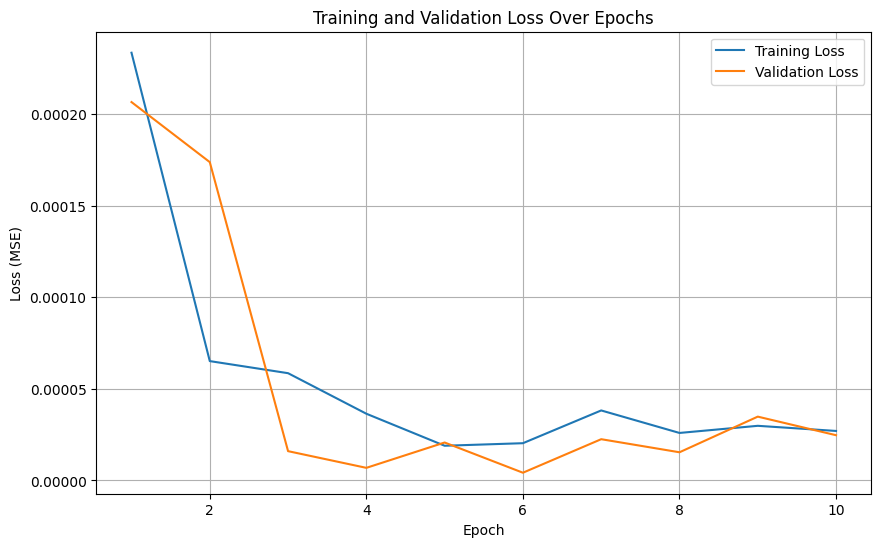

In [8]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

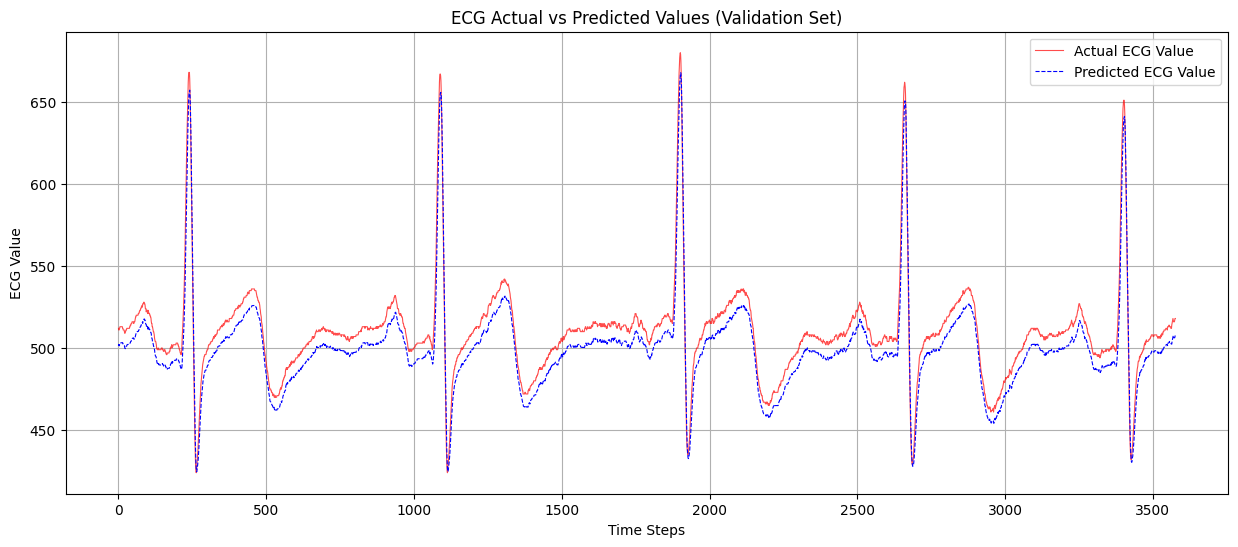


--- Single Sequence Prediction Example (First in Validation) ---
Input Sequence (last 5 values, scaled): ...[-0.28787879 -0.28787879 -0.28787879 -0.29545455 -0.29545455]
Actual Next Value (scaled): -0.3030, Original: 512.0000
Predicted Next Value (scaled): -0.3682, Original: 503.3923
Difference (Original Scale): 8.6077

--- Loading ECG data for plot... ---
    time  ecg_value
0  0.000        496
1  0.001        496
2  0.002        497
3  0.003        498
4  0.004        498
Total data points: 17935
Calculated time step (dt): 0.001000s (Implies Fs = 1000.00 Hz)
Assumed Sampling Rate: 1000 Hz
Test Points (last 0.5s): 500
Training points: 17435 (17.43s)
Testing points: 500 (0.50s)


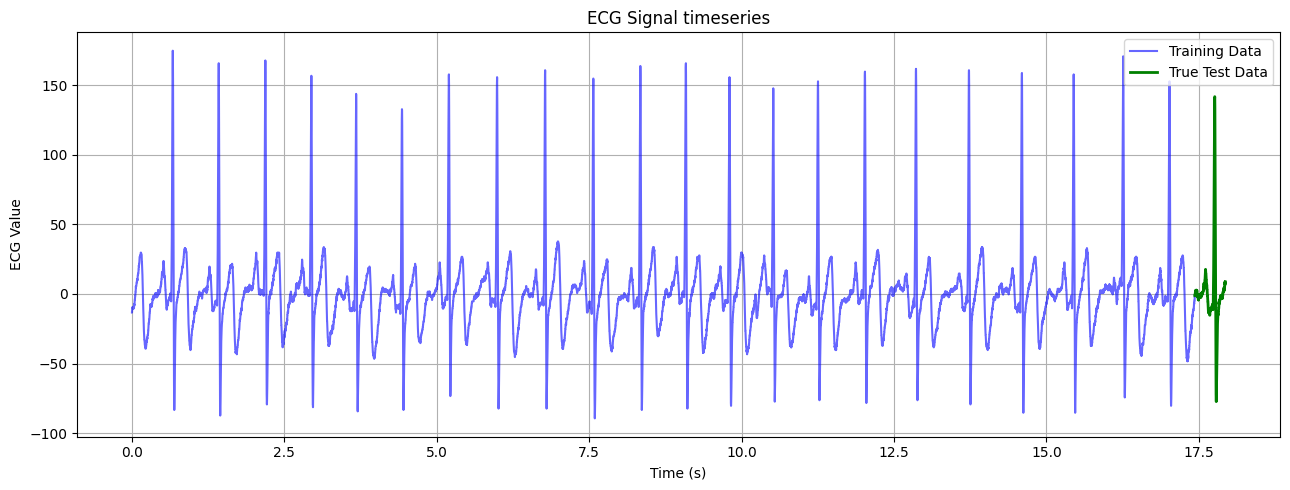

In [9]:
# --- Plotting Results ---
model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for i in range(0, len(val_data), batch_size):
         data, targets = get_batch(val_data, i, batch_size)
         output = model(data)
         # Collect predictions and targets for the whole batch
         all_predictions.extend(output.squeeze().cpu().numpy())
         all_targets.extend(targets.squeeze().cpu().numpy())


# Inverse transform predictions and targets back to original scale
preds_original = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1)).flatten()
targets_original = scaler.inverse_transform(np.array(all_targets).reshape(-1, 1)).flatten()

plt.figure(figsize=(15, 6))
plt.plot(targets_original, label='Actual ECG Value', color='red', alpha=0.7, linewidth=0.8)
plt.plot(preds_original, label='Predicted ECG Value', color='blue', linestyle='--', linewidth=0.8)
plt.title('ECG Actual vs Predicted Values (Validation Set)')
plt.xlabel('Time Steps')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True)
plt.show()

# Example of predicting a single sequence
example_idx = 0 # Start of validation set
example_seq_raw = series_scaled[len(train_data) + example_idx : len(train_data) + example_idx + input_window]
example_input = torch.tensor(example_seq_raw).float().unsqueeze(0).unsqueeze(-1).to(device) # Shape: (1, input_window, 1)

model.eval()
with torch.no_grad():
    pred_single_full = model(example_input) # This predicts the whole output window
    # For a single-step prediction (output_window=1), we take the first output
    pred_single = pred_single_full[:, 0, :] # Shape: (1, 1)

actual_next_value_scaled = series_scaled[len(train_data) + example_idx + input_window]
predicted_next_value_scaled = pred_single.item() # Get the scalar value

# Inverse transform the single prediction and actual value
actual_next_orig = scaler.inverse_transform([[actual_next_value_scaled]])[0][0]
predicted_next_orig = scaler.inverse_transform([[predicted_next_value_scaled]])[0][0]

print("\n--- Single Sequence Prediction Example (First in Validation) ---")
print(f"Input Sequence (last 5 values, scaled): ...{example_seq_raw[-5:]}")
print(f"Actual Next Value (scaled): {actual_next_value_scaled:.4f}, Original: {actual_next_orig:.4f}")
print(f"Predicted Next Value (scaled): {predicted_next_value_scaled:.4f}, Original: {predicted_next_orig:.4f}")
print(f"Difference (Original Scale): {abs(actual_next_orig - predicted_next_orig):.4f}")

# --- Plot requested data ---
# --- 1. Load and Prepare ECG Data ---
print("\n--- Loading ECG data for plot... ---")
df_plot = pd.read_csv(url_link, delimiter=';')
print(df_plot.head())
print(f"Total data points: {len(df_plot)}")
dt_calculated = df_plot['time'].diff().mean()
print(f"Calculated time step (dt): {dt_calculated:.6f}s (Implies Fs = {1/dt_calculated:.2f} Hz)")
fs = 1/dt_calculated

time_full = df_plot['time'].values
ecg_full = df_plot['ecg_value'].values
ecg_full = ecg_full - ecg_full.mean() # Detrend

# Define split: last 0.5 seconds for testing
test_duration_sec = 0.5
sampling_rate = int(np.round(1.0 / dt_calculated))
test_points = int(test_duration_sec * sampling_rate)

print(f"Assumed Sampling Rate: {sampling_rate} Hz")
print(f"Test Points (last {test_duration_sec}s): {test_points}")

time_train = time_full[:-test_points]
ecg_train = ecg_full[:-test_points]
time_test = time_full[-test_points:]
ecg_test_true = ecg_full[-test_points:]

print(f"Training points: {len(ecg_train)} ({time_train[-1] - time_train[0]:.2f}s)")
print(f"Testing points: {len(ecg_test_true)} ({time_test[-1] - time_test[0]:.2f}s)")

# Plot 1: Full time series with predictions highlighted
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

ax.plot(time_train, ecg_train, label='Training Data', color='blue', alpha=0.6)
ax.plot(time_test, ecg_test_true, label='True Test Data', color='green', linewidth=2)
ax.set_title('ECG Signal timeseries')
ax.set_xlabel('Time (s)')
ax.set_ylabel('ECG Value')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()